Adaptive Distances
==================

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('DistanceFunction')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1*scipy.randn(),
            'ss2': 2 + 10*scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as1.db")
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:Epsilon:initial epsilon is 7.697899294086873
INFO:History:Start <ABCSMC(id=2, start_time=2018-04-09 11:59:49.104574, end_time=None)>
INFO:ABC:t:0 eps:7.697899294086873
INFO:ABC:t:1 eps:5.025019722760606
INFO:ABC:t:2 eps:3.4693541413986013
INFO:ABC:t:3 eps:2.3632111187790743
INFO:ABC:t:4 eps:1.5761683729363158
INFO:ABC:t:5 eps:1.2269188598580374
INFO:ABC:t:6 eps:0.8477380860822427
INFO:ABC:t:7 eps:0.6196901238306798
INFO:History:Done <ABCSMC(id=2, start_time=2018-04-09 11:59:49.104574, end_time=2018-04-09 12:00:34.418106)>


Let us visualize the results for the non-adaptive distance:

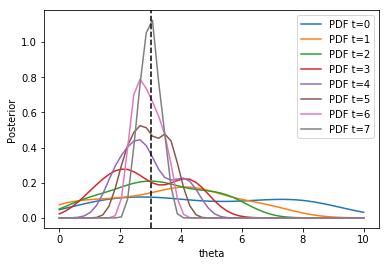

In [3]:
fig, ax = pyplot.subplots()
for t in range(history1.max_t + 1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

Second, we consider an adaptive Euclidean distance:

In [4]:
distance = pyabc.WeightedPNormDistance(p=2, adaptive=True)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

DEBUG:DistanceFunction:update distance weights = {'ss1': 1.3050306990042659, 'ss2': 0.69496930099573395}
INFO:Epsilon:initial epsilon is 5.451901756676551
INFO:History:Start <ABCSMC(id=10, start_time=2018-04-09 12:00:35.251677, end_time=None)>
INFO:ABC:t:0 eps:5.451901756676551
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.4697931307477279, 'ss2': 0.53020686925227223}
INFO:ABC:t:1 eps:3.356131098782557
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.6629819588977277, 'ss2': 0.33701804110227224}
INFO:ABC:t:2 eps:2.1072387210958454
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.7457461875520623, 'ss2': 0.25425381244793771}
INFO:ABC:t:3 eps:1.240257748440571
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.8575795510870328, 'ss2': 0.14242044891296732}
INFO:ABC:t:4 eps:0.6497542859838952
DEBUG:DistanceFunction:update distance weights = {'ss1': 1.9061341675103178, 'ss2': 0.093865832489682097}
INFO:ABC:t:5 eps:0.38514013065814534
DEBUG:DistanceFu

In the debug output of abc.run above, it can be seen how the weights evolve over time. Let us visualize the results for the adaptive distance:

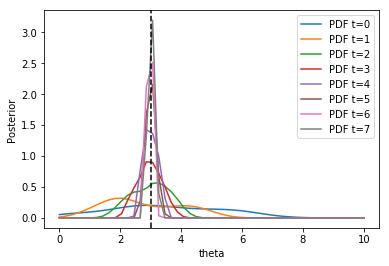

In [5]:
fig, ax = pyplot.subplots()
for t in range(history2.max_t + 1):
    df, w = history2.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                   x='theta', ax=ax,
                                   label="PDF t={}".format(t))
ax.axvline(theta_true, color='k', linestyle='dashed')
ax.legend()
pyplot.show()

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$.